In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, padding_mode='reflect'),transforms.RandomHorizontalFlip(),transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform1 = transforms.Compose([transforms.ToTensor(), 
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform1)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 100
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2)


In [5]:
len(trainloader)

500

In [6]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
labels.shape

torch.Size([100])

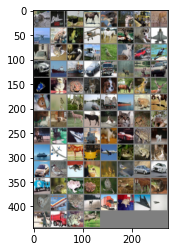

  cat plane  bird horse   dog  bird truck  deer plane  frog  frog plane horse  deer   dog plane truck   cat  bird  ship  bird   dog   car  bird   car  ship  ship   car truck  deer  deer   car truck   dog  frog   cat   dog horse  frog  deer   dog  bird  frog  ship truck  ship  frog horse   dog   cat  deer horse   dog   cat  frog  frog horse  deer  ship  ship   cat   car  frog   dog  ship plane horse   car plane  frog  frog   cat   car  bird   cat  frog  bird  bird   car   car truck  frog  frog  frog  bird  frog horse  frog   dog plane   cat  deer truck   dog plane plane horse truck  frog  bird


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5      # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [8]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.pool = nn.MaxPool2d(2, 2)
        self.bn1=nn.BatchNorm2d(32)
        self.bn2=nn.BatchNorm2d(64)
        self.bn3=nn.BatchNorm2d(128)
        self.bn4=nn.BatchNorm2d(256)
        

        self.conv1 = nn.Conv2d(3, 32, 3,padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3,padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3,padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)
        
        
        self.fc1 = nn.Linear(256 * 2 * 2, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 10)
        
        
        self.dropout = nn.Dropout(p=.50)


    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))


        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x=self.fc3(x)
        return F.log_softmax(x, dim=1)

net = Net()

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [10]:
lossTracker = []
 
for epoch in range(15):
    running_loss = 0.0
    running_loss_track=0.0
    for i, data in enumerate(trainloader, 0):
      # get the inputs; data is a list of [inputs, labels]
      inputs, labels = data

      # Zero the parameter gradients
      optimizer.zero_grad()

      # Forward + backward + optimize
      outputs = net(inputs)
      loss = criterion(outputs, labels)  
      loss.backward()
      optimizer.step()

      #print statistics
      running_loss += loss.item()

    
      if i % 100 == 99: # print every 1000 mini-batches
        print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 100))
        running_loss_track+=running_loss/100
        running_loss = 0.0
    
    # calculate average losses
    running_loss_track=running_loss_track/5
    print(running_loss_track)
    lossTracker.append(running_loss_track)
    
print("Training Finished.")
  


[1,   100] loss: 1.854
[1,   200] loss: 1.531
[1,   300] loss: 1.420
[1,   400] loss: 1.319
[1,   500] loss: 1.281
1.4811278785467148
[2,   100] loss: 1.227
[2,   200] loss: 1.188
[2,   300] loss: 1.131
[2,   400] loss: 1.115
[2,   500] loss: 1.084
1.1489427620172499
[3,   100] loss: 1.047
[3,   200] loss: 1.017
[3,   300] loss: 1.018
[3,   400] loss: 0.977
[3,   500] loss: 0.956
1.0026451232433318
[4,   100] loss: 0.922
[4,   200] loss: 0.936
[4,   300] loss: 0.911
[4,   400] loss: 0.890
[4,   500] loss: 0.869
0.9055953068733216
[5,   100] loss: 0.862
[5,   200] loss: 0.855
[5,   300] loss: 0.827
[5,   400] loss: 0.844
[5,   500] loss: 0.808
0.8392810305356979
[6,   100] loss: 0.780
[6,   200] loss: 0.792
[6,   300] loss: 0.778
[6,   400] loss: 0.745
[6,   500] loss: 0.785
0.7760957320332527
[7,   100] loss: 0.728
[7,   200] loss: 0.735
[7,   300] loss: 0.719
[7,   400] loss: 0.726
[7,   500] loss: 0.740
0.729500229537487
[8,   100] loss: 0.688
[8,   200] loss: 0.714
[8,   300] loss: 

In [11]:
len(trainloader)

500

In [12]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

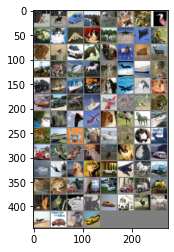

GroundTruth:    dog horse   car  deer  bird  frog  deer  bird   cat   cat plane   dog horse plane  ship  bird  frog  bird   car horse   cat horse  frog  deer plane  frog plane horse   dog plane  ship  bird truck  ship  ship   car   dog plane   cat   dog   car   car  frog  ship plane  deer   dog  frog   cat   dog  bird plane   dog  bird horse  ship  deer  ship   cat  deer  ship  deer   cat  deer truck  bird  frog horse  deer   dog   dog truck  ship plane   dog  frog   car plane horse truck   cat  frog truck   cat   car   car truck truck   cat  frog   cat   dog   car truck  deer horse plane   car  bird   car


In [13]:
dataiter = iter(testloader)

images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [14]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
outputs = net(images)

In [16]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(5)))

Predicted:    dog horse   car plane  bird


In [17]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 81 %


In [18]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 75.8 %
Accuracy for class car   is: 90.7 %
Accuracy for class bird  is: 75.9 %
Accuracy for class cat   is: 69.5 %
Accuracy for class deer  is: 82.6 %
Accuracy for class dog   is: 72.7 %
Accuracy for class frog  is: 86.7 %
Accuracy for class horse is: 81.7 %
Accuracy for class ship  is: 88.4 %
Accuracy for class truck is: 90.2 %


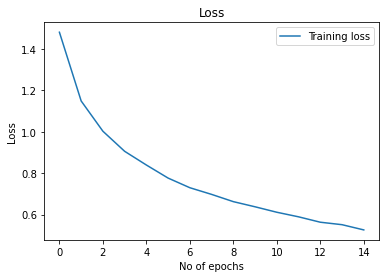

In [20]:
plt.plot(np.arange(0, 15), lossTracker, label='Training loss')
plt.title('Loss')
plt.xlabel('No of epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()